<a href="https://colab.research.google.com/github/Looking-forward-to-Ctrlc-Ctrlv/Investigating-Strategies-for-Diabetic-Retina-Fundus-Image-Synthesis-using-GANs/blob/main/Finals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


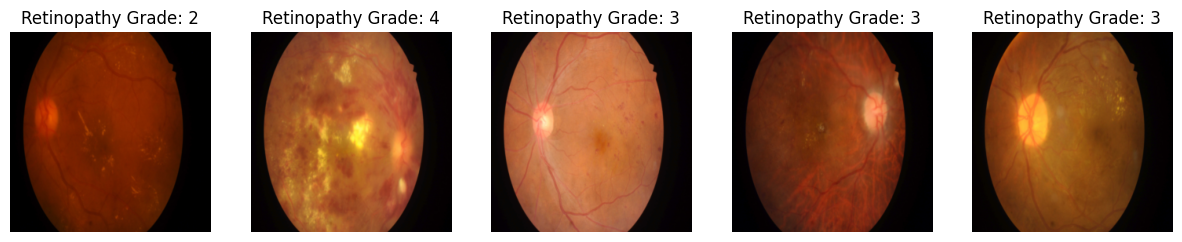

In [ ]:
import os
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

# Define paths to CSV files and image folders
train_csv_path = '/content/drive/MyDrive/docs/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_csv_path = '/content/drive/MyDrive/docs/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
train_image_folder = '/content/drive/MyDrive/docs/1. Original Images/a. Training Set'
test_image_folder = '/content/drive/MyDrive/docs/1. Original Images/b. Testing Set'

# Load CSV files
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

# Initialize lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Set the maximum number of images to load (e.g., 40)
max_images = 40

# Load training images and labels
for image_file in os.listdir(train_image_folder):
    if image_file.endswith('.jpg') and len(train_images) < max_images:
        image_path = os.path.join(train_image_folder, image_file)
        image = io.imread(image_path)
        train_images.append(image)

        # Use the 'Image name' column to match image filenames
        label = train_csv.loc[train_csv['Image name'] == image_file[:-4], 'Retinopathy grade'].values[0]  # Remove '.jpg' extension
        train_labels.append(label)

# Load testing images and labels
for image_file in os.listdir(test_image_folder):
    if image_file.endswith('.jpg') and len(test_images) < max_images:
        image_path = os.path.join(test_image_folder, image_file)
        image = io.imread(image_path)
        test_images.append(image)

        # Use the 'Image name' column to match image filenames
        label = test_csv.loc[test_csv['Image name'] == image_file[:-4], 'Retinopathy grade'].values[0]  # Remove '.jpg' extension
        test_labels.append(label)

# Preprocess images (resize only, no normalization)
def preprocess_images(images):
    target_size = (256, 256)  # Adjust as needed
    preprocessed_images = [transform.resize(image, target_size) for image in images]
    return preprocessed_images

train_images_preprocessed = preprocess_images(train_images)
test_images_preprocessed = preprocess_images(test_images)

plt.figure(figsize=(15, 5))

# Display the first 5 preprocessed images (or fewer if there are less than 5)
for i in range(min(5, max_images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images_preprocessed[i])
    plt.title(f'Retinopathy Grade: {train_labels[i]}')
    plt.axis('off')

plt.show()




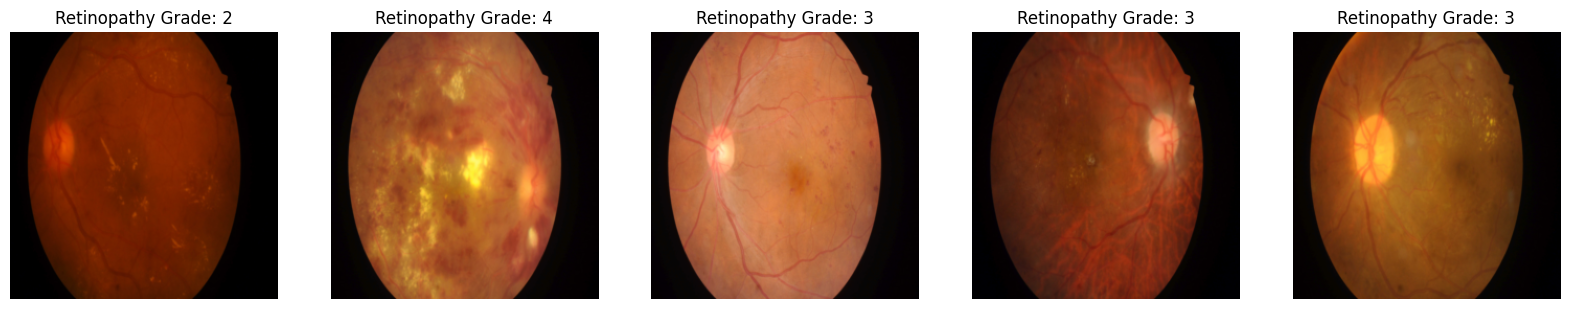

In [ ]:

plt.figure(figsize=(20, 20))

# Display the first 5 preprocessed images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images_preprocessed[i])
    plt.title(f'Retinopathy Grade: {train_labels[i]}')
    plt.axis('off')

plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Epoch 8100, D Loss: 0.4764936566352844, G Loss: 21.879898071289062

Generator Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0      

TypeError: ignored

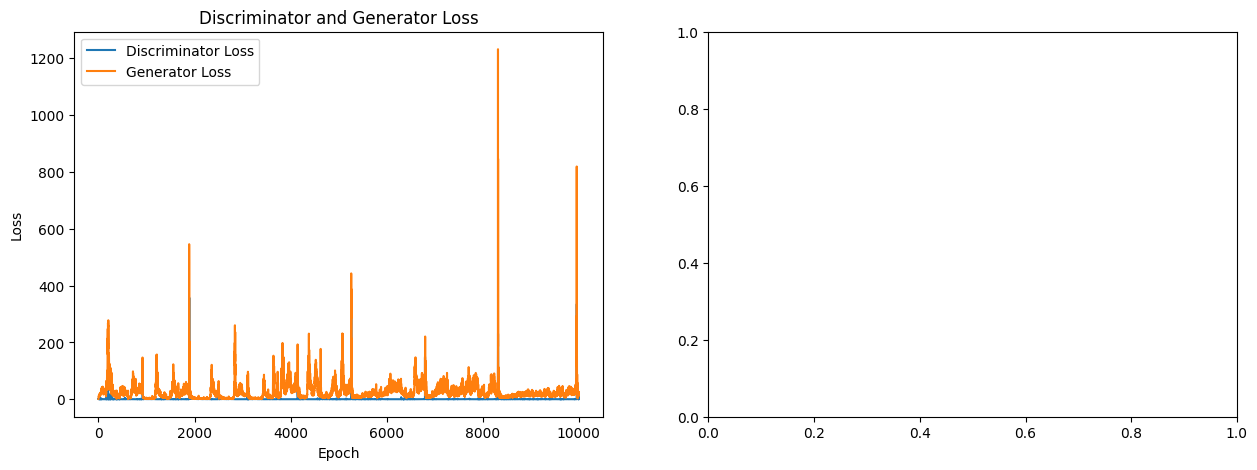

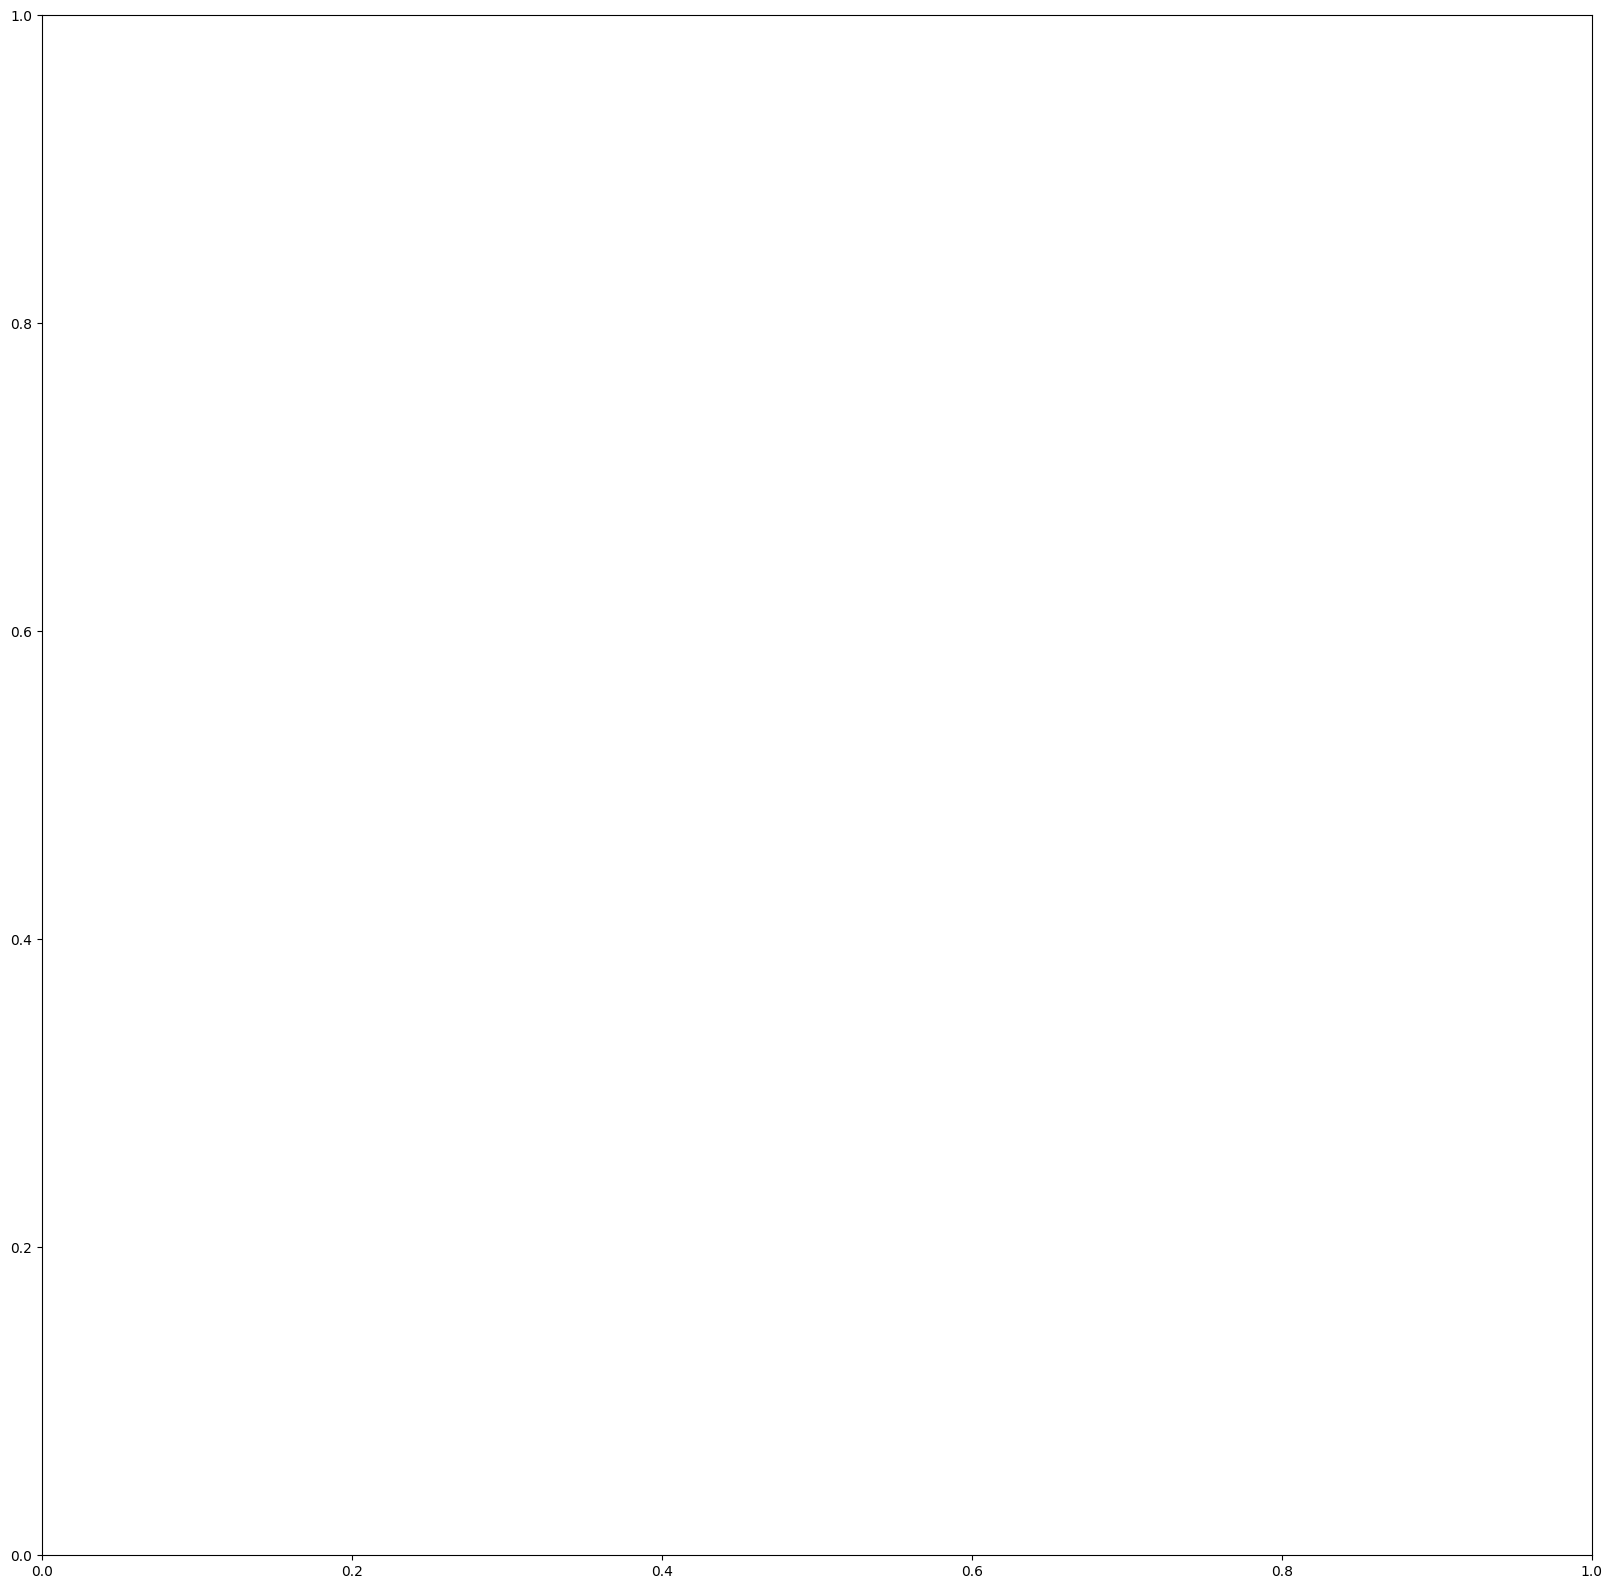

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

# Initialize lists to store losses
d_loss_list = []
g_loss_list = []

# Define the generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256 * 256 * 3, activation='tanh'))
    model.add(Reshape((256, 256, 3)))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 3)))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile the discriminator and generator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False  # Freeze the discriminator during GAN training

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training parameters
epochs = 10000
batch_size = 32
save_interval = 1000

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Training the GAN
def train_gan(epochs, batch_size):
    num_samples = len(train_images_preprocessed)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        np.random.shuffle(train_images_preprocessed)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            batch_images = np.array(train_images_preprocessed[start_idx:end_idx])

            noise = np.random.normal(0, 1, (batch_size, 100))

            gen_imgs = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(batch_images, valid)  # Use real images
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # Use generated images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = combined.train_on_batch(noise, valid)

        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Append losses to lists
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)

        if epoch % save_interval == 0:
            save_generated_images(epoch)

        if epoch % 100 == 0:  # Adjust frequency for printing model summary and loss graphs
            print_model_summary()

# Print model summary
def print_model_summary():
    print("\nGenerator Summary:")
    generator.summary()
    print("\nDiscriminator Summary:")
    discriminator.summary()

# After training loop, plot the loss graphs
def plot_loss(epoch, d_loss, g_loss):
    epochs_range = range(epoch + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, d_loss, label='Discriminator Loss')
    plt.plot(epochs_range, g_loss, label='Generator Loss')
    plt.title('Discriminator and Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    save_generated_images(epoch, examples=1)  # Save a generated image for visualization
    img = plt.imread(f"gan_generated_image_epoch_{epoch}.png")
    plt.imshow(img)
    plt.title(f'Generated Image at Epoch {epoch}')
    plt.axis('off')

    plt.show()

# Save generated images
def save_generated_images(epoch, examples=10):
    noise = np.random.normal(0, 1, (examples, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(1, examples, figsize=(20, 20))
    cnt = 0
    for i in range(examples):
        axs[i].imshow(gen_imgs[cnt])
        axs[i].axis('off')
        cnt += 1
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()

# Train the GAN
train_gan(epochs=epochs, batch_size=batch_size)

# Plot the loss graphs after the entire training is complete
plot_loss(epochs-1, d_loss_list, g_loss_list)


1/1 [==============================] - 0s 30ms/step


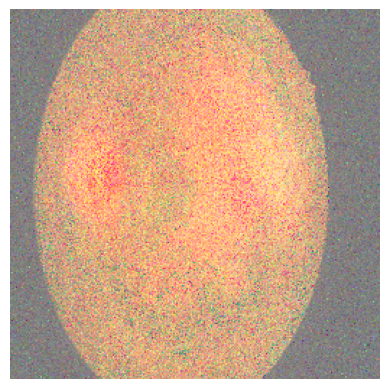

In [ ]:
def generate_and_save_image(output_path):
    noise = np.random.normal(0, 1, (1, 100))
    gen_img = generator.predict(noise)
    gen_img = 0.5 * gen_img + 0.5  # Rescale to [0, 1]

    # Ensure the image shape is (256, 256, 3)
    gen_img = gen_img.reshape(256, 256, 3)

    plt.imshow(gen_img)
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

# Generate and save a color image
generate_and_save_image("generated_image.png")


In [ ]:
from tensorflow.keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.applications import VGG16  # Add this import statement
# Define the generator
def build_generator():
    model = Sequential()
    model.add(Dense(32, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256 * 256 * 3, activation='tanh'))
    model.add(Reshape((256, 256, 3)))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 3)))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Print model summary
def print_model_summary():
    generator = build_generator()
    discriminator = build_discriminator()

    print("\nGenerator Summary:")
    generator.summary()

    print("\nDiscriminator Summary:")
    discriminator.summary()

# Call the function to print the summaries
print_model_summary()



Generator Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3232      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                 

1/1 [==============================] - 0s 27ms/step


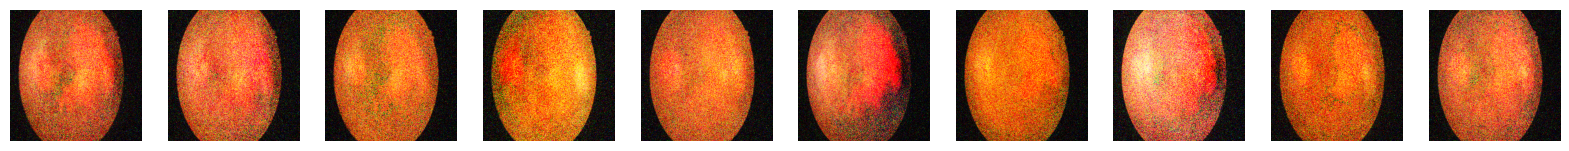

In [ ]:
def generated_images(epoch, examples=10):
    noise = np.random.normal(0, 1, (examples, 100))
    gen_imgs = generator.predict(noise)
    # gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(1, examples, figsize=(20, 20))
    cnt = 0
    for i in range(examples):
        axs[i].imshow(gen_imgs[cnt],cmap='gray')
        axs[i].axis('off')
        cnt += 1
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

generated_images(1)